In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Downloading Data

In [2]:
niftybees = yf.download("NIFTYBEES.BO", start="2000-01-01", end="2025-01-09", interval="1mo")
goldbees = yf.download("GOLDBEES.BO", start="2000-01-01", end="2025-01-09", interval="1mo")

# Ensure only monthly closing prices are kept
niftybees = niftybees["Adj Close"]['NIFTYBEES.BO']
goldbees = goldbees["Adj Close"]['GOLDBEES.BO']['2010-03-01':]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Generating Signals and Running the Strategy

In [92]:
data = pd.concat([niftybees, goldbees], axis=1).dropna()

data.columns = ["NIFTYBEES", "GOLDBEES"]

# data['lagged_1_year_avg_pe'] = data['P/E'].rolling(12).mean()

# data = data['2014-11-01':'2021-03-01']

short_term_momentum_months = [1,2,3,4,5,6]
long_term_momentum_months = [6,7,8,9,10,11,12]

data["NIFTYBEES_Return"] = data["NIFTYBEES"].pct_change()
data["GOLDBEES_Return"] = data["GOLDBEES"].pct_change()

cummulative_column_names = []
return_column_names = []

for short_term_window in short_term_momentum_months:
    for long_term_window in long_term_momentum_months:
        short_term_column_name = 'lagged_' + str(short_term_window) + 'month' + '_momentum_short'
        long_term_column_name = 'lagged_' + str(long_term_window) + 'month' + '_momentum_long'
        
        data[short_term_column_name] = data['NIFTYBEES'].shift(1)/data['NIFTYBEES'].shift(short_term_window+1)
        data[long_term_column_name] = data['NIFTYBEES'].shift(1)/data['NIFTYBEES'].shift(long_term_window+1)

        # data = data.iloc[long_term_window+1:]
        # Generate signals
        signal_column_name = str(short_term_window) + '_' + str(long_term_window)
        data[signal_column_name] = np.where((data[short_term_column_name] > 1) | (data[long_term_column_name] > 1), "NIFTYBEES", "GOLDBEES")

        # Calculate returns
        strategy_column_name = str(short_term_window) + '_' + str(long_term_window) + '_' + 'return'
        data[strategy_column_name] = np.where(
            data[signal_column_name] == "NIFTYBEES", data["NIFTYBEES_Return"], data["GOLDBEES_Return"]
            )
        strategy_cummulative_column_name = strategy_column_name + 'cummulative'
        data[strategy_cummulative_column_name] = (1 + data[strategy_column_name]).cumprod()
        cummulative_column_names.append(strategy_cummulative_column_name)
        return_column_names.append(strategy_column_name)

data["Cumulative_NIFTYBEES"] = (1 + data["NIFTYBEES_Return"]).cumprod()


C:\Users\rajme\AppData\Local\Temp\ipykernel_2652\1571510018.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[strategy_column_name] = np.where(
C:\Users\rajme\AppData\Local\Temp\ipykernel_2652\1571510018.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[strategy_cummulative_column_name] = (1 + data[strategy_column_name]).cumprod()
C:\Users\rajme\AppData\Local\Temp\ipykernel_2652\1571510018.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [93]:
data.head(10)

,NIFTYBEES,GOLDBEES,NIFTYBEES_Return,GOLDBEES_Return,lagged_1month_momentum_short,lagged_6month_momentum_long,1_6,1_6_return,1_6_returncummulative,lagged_7month_momentum_long,...,6_10,6_10_return,6_10_returncummulative,6_11,6_11_return,6_11_returncummulative,6_12,6_12_return,6_12_returncummulative,Cumulative_NIFTYBEES
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-01,52.619999,16.080200,NaN,NaN,NaN,NaN,GOLDBEES,NaN,NaN,NaN,...,GOLDBEES,NaN,NaN,GOLDBEES,NaN,NaN,GOLDBEES,NaN,NaN,NaN
2010-04-01,52.404999,16.711500,-0.004086,0.039259,NaN,NaN,GOLDBEES,0.039259,1.039259,NaN,...,GOLDBEES,0.039259,1.039259,GOLDBEES,0.039259,1.039259,GOLDBEES,0.039259,1.039259,0.995914
2010-05-01,50.630001,17.943501,-0.033871,0.073722,0.995914,NaN,GOLDBEES,0.073722,1.115875,NaN,...,GOLDBEES,0.073722,1.115875,GOLDBEES,0.073722,1.115875,GOLDBEES,0.073722,1.115875,0.962182
2010-06-01,53.275002,18.531500,0.052242,0.032769,0.966129,NaN,GOLDBEES,0.032769,1.152442,NaN,...,GOLDBEES,0.032769,1.152442,GOLDBEES,0.032769,1.152442,GOLDBEES,0.032769,1.152442,1.012448
2010-07-01,54.189999,17.516199,0.017175,-0.054788,1.052242,NaN,NIFTYBEES,0.017175,1.172235,NaN,...,GOLDBEES,-0.054788,1.089302,GOLDBEES,-0.054788,1.089302,GOLDBEES,-0.054788,1.089302,1.029837
2010-08-01,53.900002,18.573299,-0.005351,0.060350,1.017175,NaN,NIFTYBEES,-0.005351,1.165962,NaN,...,GOLDBEES,0.060350,1.155042,GOLDBEES,0.060350,1.155042,GOLDBEES,0.060350,1.155042,1.024325
2010-09-01,60.099998,18.804600,0.115028,0.012453,0.994649,NaN,GOLDBEES,0.012453,1.180482,NaN,...,GOLDBEES,0.012453,1.169426,GOLDBEES,0.012453,1.169426,GOLDBEES,0.012453,1.169426,1.142151
2010-10-01,60.200001,19.011499,0.001664,0.011003,1.115028,1.142151,NIFTYBEES,0.001664,1.182446,NaN,...,NIFTYBEES,0.001664,1.171372,NIFTYBEES,0.001664,1.171372,NIFTYBEES,0.001664,1.171372,1.144052
2010-11-01,59.700001,19.919800,-0.008306,0.047776,1.001664,1.148745,NIFTYBEES,-0.008306,1.172626,1.144052,...,NIFTYBEES,-0.008306,1.161643,NIFTYBEES,-0.008306,1.161643,NIFTYBEES,-0.008306,1.161643,1.134550


## Plot Portfolio Values for Strategies

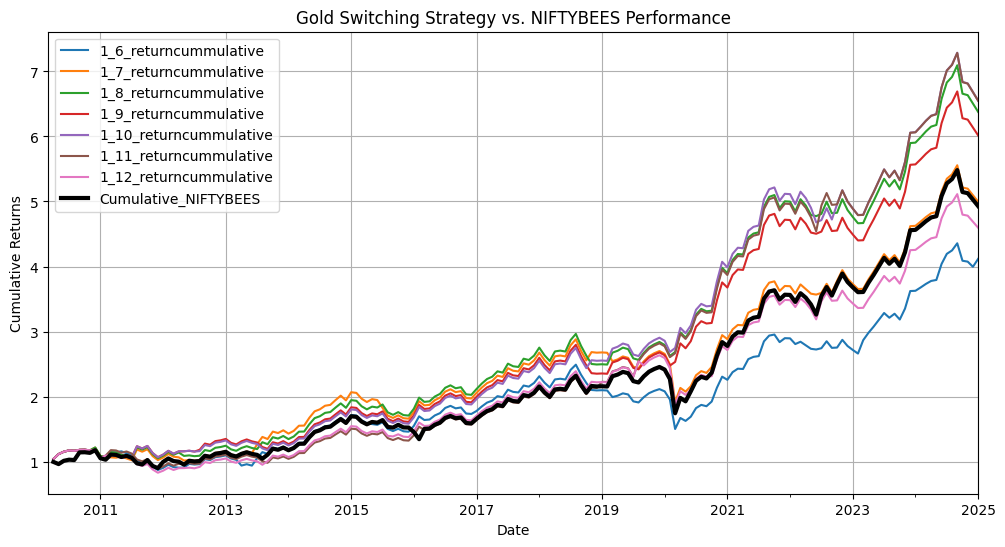

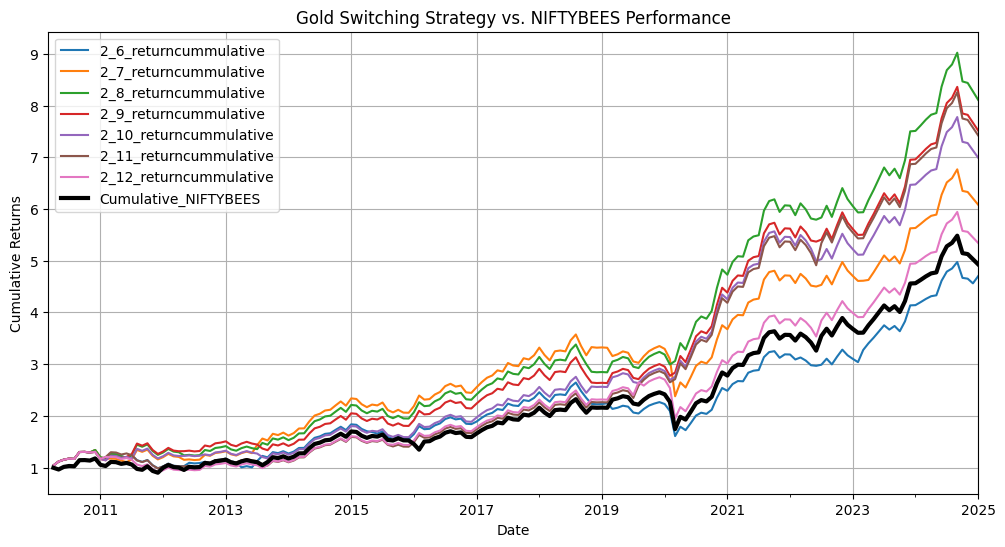

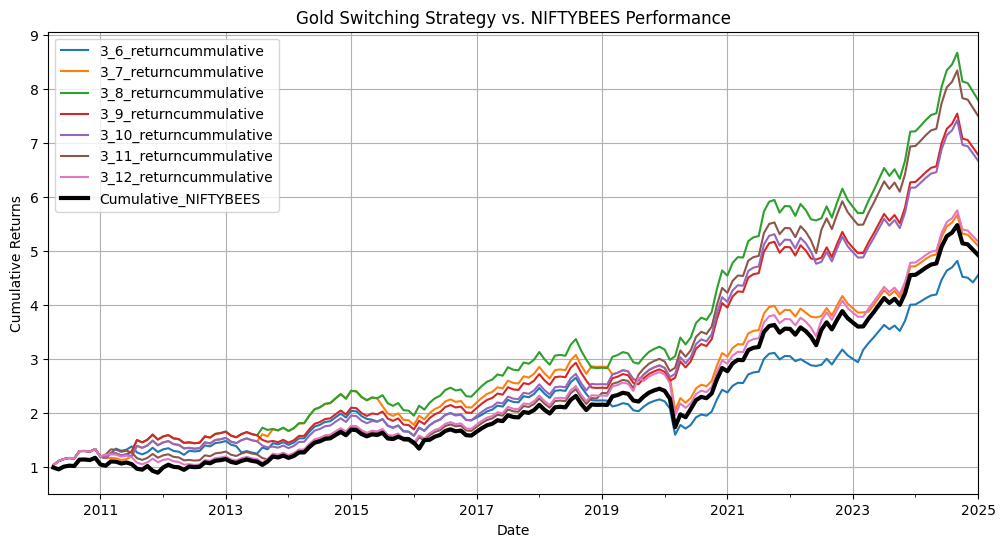

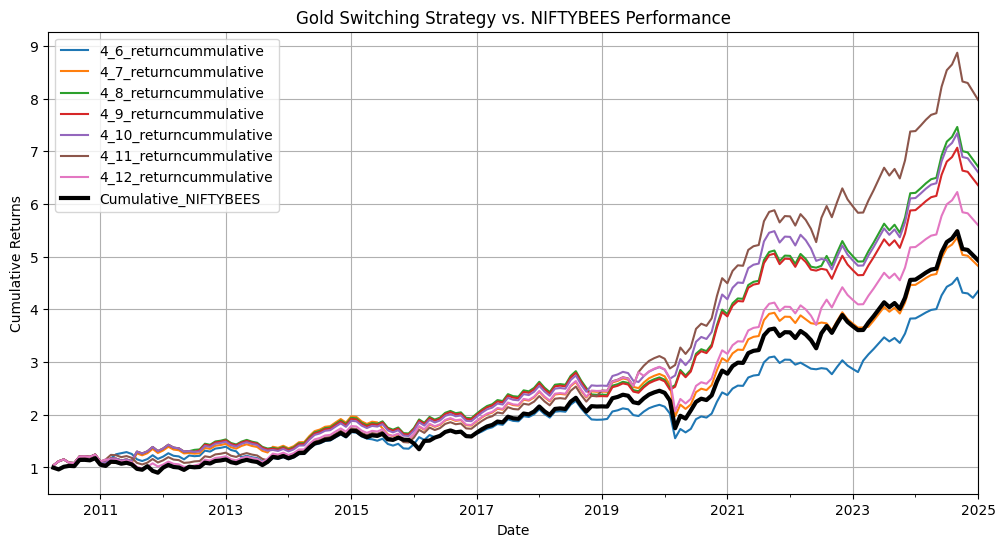

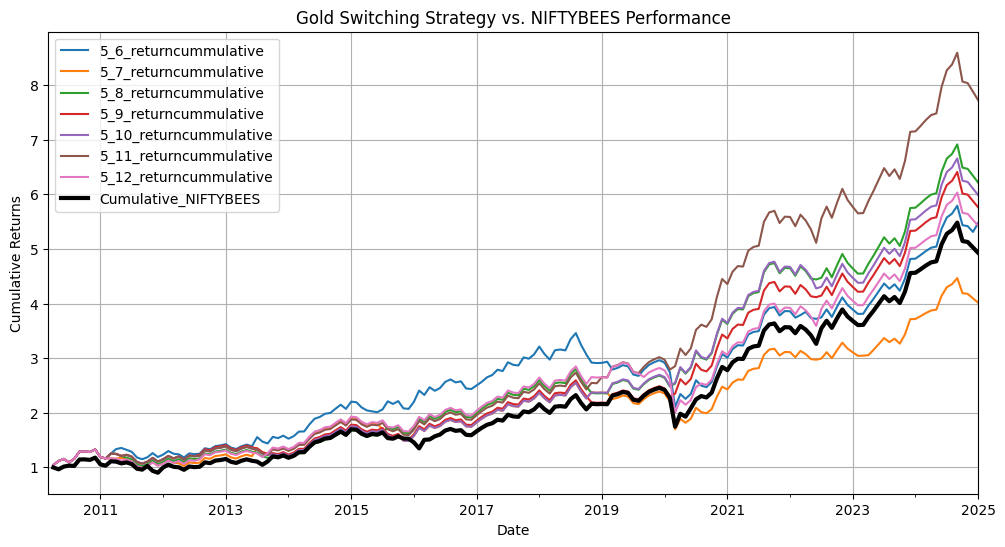

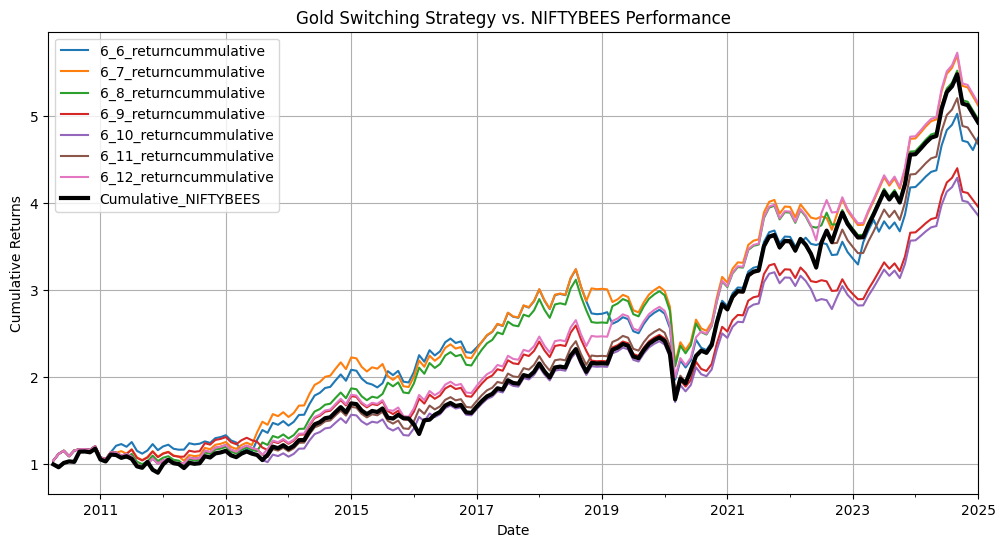

In [113]:
# Plot performance

for short_term_window in short_term_momentum_months:
    fig, ax = plt.subplots(figsize=(12, 6))

    plot_columns = [x for x in cummulative_column_names if x[0] == str(short_term_window)]

    # Plot the cumulative returns
    data[plot_columns].plot(ax=ax)

    # # Add coloring based on the 'Signal' column
    # for i in range(len(data) - 1):
    #     if data.iloc[i]["Signal"] == "GOLDBEES":
    #         ax.axvspan(data.index[i], data.index[i + 1], color="yellow", alpha=0.3)

    data["Cumulative_NIFTYBEES"].plot(ax=ax, linewidth=3, color='black')


    # Add title, labels, legend, and grid
    plt.title("Gold Switching Strategy vs. NIFTYBEES Performance")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.show()

## Read Risk Free Data

In [95]:
risk_free = pd.read_csv("risk_free_rate_india.csv")
risk_free['Date'] = pd.to_datetime(risk_free['Date'], format='%d-%m-%Y')
risk_free.set_index('Date', inplace=True)
data_metrics = pd.merge(data, risk_free, left_index=True, right_index=True , how='inner')
data_metrics = data_metrics.rename(columns={'Price': 'risk_free'})
data_metrics['risk_free'] = data_metrics['risk_free']/(100*12)


In [96]:
data_metrics

,NIFTYBEES,GOLDBEES,NIFTYBEES_Return,GOLDBEES_Return,lagged_1month_momentum_short,lagged_6month_momentum_long,1_6,1_6_return,1_6_returncummulative,lagged_7month_momentum_long,...,6_11_returncummulative,6_12,6_12_return,6_12_returncummulative,Cumulative_NIFTYBEES,risk_free,Open,High,Low,Change %
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-01,52.619999,16.080200,NaN,NaN,NaN,NaN,GOLDBEES,NaN,NaN,NaN,...,NaN,GOLDBEES,NaN,NaN,NaN,0.006542,7.920,8.015,7.738,-0.18%
2010-04-01,52.404999,16.711500,-0.004086,0.039259,NaN,NaN,GOLDBEES,0.039259,1.039259,NaN,...,1.039259,GOLDBEES,0.039259,1.039259,0.995914,0.006718,7.843,8.124,7.772,2.69%
2010-05-01,50.630001,17.943501,-0.033871,0.073722,0.995914,NaN,GOLDBEES,0.073722,1.115875,NaN,...,1.115875,GOLDBEES,0.073722,1.115875,0.962182,0.006303,8.070,8.070,7.368,-6.17%
2010-06-01,53.275002,18.531500,0.052242,0.032769,0.966129,NaN,GOLDBEES,0.032769,1.152442,NaN,...,1.152442,GOLDBEES,0.032769,1.152442,1.012448,0.006301,7.564,7.686,7.463,-0.04%
2010-07-01,54.189999,17.516199,0.017175,-0.054788,1.052242,NaN,NIFTYBEES,0.017175,1.172235,NaN,...,1.089302,GOLDBEES,-0.054788,1.089302,1.029837,0.006502,7.521,7.803,7.521,3.20%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,288.489990,63.540001,0.025815,0.047823,1.012639,1.154806,NIFTYBEES,0.025815,4.357090,1.171109,...,5.208263,NIFTYBEES,0.025815,5.730669,5.482516,0.005625,6.877,6.885,6.706,-1.65%
2024-10-01,270.730011,66.919998,-0.061562,0.053195,1.025815,1.167361,NIFTYBEES,-0.061562,4.088859,1.184618,...,4.887633,NIFTYBEES,-0.061562,5.377879,5.145002,0.005700,6.759,6.875,6.730,1.33%
2024-11-01,269.809998,64.290001,-0.003398,-0.039301,0.938438,1.082271,NIFTYBEES,-0.003398,4.074964,1.095496,...,4.871024,NIFTYBEES,-0.003398,5.359603,5.127518,0.005625,6.831,6.863,6.739,-1.32%


## Performance Metrics for NIFTY

In [97]:
### NIFTY Metrics

# Sharpe ratio
sharpe_ratio_n = (data_metrics["NIFTYBEES_Return"] - data_metrics['risk_free']).mean() / (data_metrics["NIFTYBEES_Return"] - data_metrics['risk_free']).std() 

# Maximum drawdown
rolling_max_n = data_metrics["Cumulative_NIFTYBEES"].cummax()
drawdown_n = (data_metrics["Cumulative_NIFTYBEES"] - rolling_max_n) / rolling_max_n
max_drawdown_n = drawdown_n.min()

# Performance metrics
performance_n = {
    "Sharpe Ratio": sharpe_ratio_n*np.sqrt(12),
    "Max Drawdown": max_drawdown_n,
    "Cumulative Return": data_metrics["Cumulative_NIFTYBEES"].iloc[-1]
}

print("Performance Metrics NIFTY:")
for metric, value in performance_n.items():
    print(f"{metric}: {value:.2f}")



Performance Metrics NIFTY:
Sharpe Ratio: 0.29
Max Drawdown: -0.29
Cumulative Return: 4.93


## Performance Metrics for Strategies

In [111]:
########## Strategy Metrics

performance_df = pd.DataFrame()

for i, return_column_name in enumerate(return_column_names):
    cum_ret_column_name = cummulative_column_names[i]

    # Sharpe ratio
    sharpe_ratio = (data_metrics[return_column_name] - data_metrics['risk_free']).mean() / (data_metrics[return_column_name] - data_metrics['risk_free']).std()

    # Maximum drawdown
    rolling_max = data_metrics[cum_ret_column_name].cummax()
    drawdown = (data_metrics[cum_ret_column_name] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Performance metrics
    performance = {
        "Strategy": return_column_name,
        "Sharpe Ratio": sharpe_ratio*np.sqrt(12),
        "Max Drawdown": max_drawdown,
        "Cumulative Return": data_metrics[cum_ret_column_name].iloc[-1]
    }

    print("\n")
    # Print results
    print("Performance Metrics:")
    for metric, value in performance.items():
        if isinstance(value, str):
            print(f"{metric}: {value}")
        else:
            print(f"{metric}: {value:.2f}")

    performance_df = pd.concat([performance_df, pd.DataFrame([performance])])



Performance Metrics:
Strategy: 1_6_return
Sharpe Ratio: 0.22
Max Drawdown: -0.40
Cumulative Return: 4.12


Performance Metrics:
Strategy: 1_7_return
Sharpe Ratio: 0.30
Max Drawdown: -0.33
Cumulative Return: 5.00


Performance Metrics:
Strategy: 1_8_return
Sharpe Ratio: 0.44
Max Drawdown: -0.16
Cumulative Return: 6.38


Performance Metrics:
Strategy: 1_9_return
Sharpe Ratio: 0.41
Max Drawdown: -0.16
Cumulative Return: 6.02


Performance Metrics:
Strategy: 1_10_return
Sharpe Ratio: 0.45
Max Drawdown: -0.14
Cumulative Return: 6.55


Performance Metrics:
Strategy: 1_11_return
Sharpe Ratio: 0.45
Max Drawdown: -0.25
Cumulative Return: 6.55


Performance Metrics:
Strategy: 1_12_return
Sharpe Ratio: 0.27
Max Drawdown: -0.30
Cumulative Return: 4.60


Performance Metrics:
Strategy: 2_6_return
Sharpe Ratio: 0.27
Max Drawdown: -0.39
Cumulative Return: 4.70


Performance Metrics:
Strategy: 2_7_return
Sharpe Ratio: 0.38
Max Drawdown: -0.33
Cumulative Return: 6.08


Performance Metrics:
Strategy: 2

In [112]:
performance_df

,Strategy,Sharpe Ratio,Max Drawdown,Cumulative Return
0,1_6_return,0.218927,-0.397060,4.117401
0,1_7_return,0.302477,-0.334476,4.995570
0,1_8_return,0.435740,-0.159166,6.377345
0,1_9_return,0.410569,-0.159166,6.015959
0,1_10_return,0.451263,-0.139908,6.551142
0,1_11_return,0.451686,-0.246118,6.548110
0,1_12_return,0.269897,-0.298965,4.596341
0,2_6_return,0.274360,-0.391722,4.700056
0,2_7_return,0.384607,-0.334476,6.082308
0,2_8_return,0.540917,-0.159166,8.109652
